# Comparison of dependency relations in evaluation

In [136]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

import sys, os
sys.path.append("../tools/")
import udeval

import pandas as pd
import seaborn as sns
from collections import defaultdict

output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/baseline-UD/"

core_dependents = ("nsubj", "csubj", "nsubjpass", "csubjpass", "dobj", "ccomp", "xcomp", "iobj")
noun_dependents = ("nummod", "appos", "nmod", "acl", "amod", "neg", "det")

system_output = {"en": "en-en.all.conll.conllu",
                 "cs": "cs-cs.all.conll.conllu",
                 "de": "de-de.all.conll.conllu",
                 "en": "en-en.all.conll.conllu",
                 "es": "es-es.all.conll.conllu",
                 "fi": "fi-fi.all.conll.conllu",
                 "fr": "fr-fr.all.conll.conllu",
                 "ga": "ga-ga.all.conll.conllu",
                 "hu": "hu-hu.all.conll.conllu",
                 "it": "it-it.all.conll.conllu",
                 "sv": "sv-sv.all.conll.conllu"}
gold_file = {"en": "en-ud-test.conllu",
             "cs": "cs-ud-test.conllu",
             "de": "de-ud-test.conllu",
             "en": "en-ud-test.conllu",
             "es": "es-ud-test.conllu",
             "fi": "fi-ud-test.conllu",
             "fr": "fr-ud-test.conllu",
             "ga": "ga-ud-test.conllu",
             "hu": "hu-ud-test.conllu",
             "it": "it-ud-test.conllu",
             "sv": "sv-ud-test.conllu"}

In [70]:
def labeled_attachment_scores():
    las = {}
    for lang in system_output.keys():
        score = udeval.attachment_score(output_path + system_output[lang], output_path + gold_file[lang], labeled=True)
        las[lang] = score
    return pd.Series(las)
        
def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang in system_output.keys():
        precision, recall = udeval.labels_precision_recall(output_path + system_output[lang], 
                                                           output_path + gold_file[lang], 
                                                           labels=labels)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

In [103]:
content_relations = ("acl", "advcl", "advmod", "amod", "appos", "ccomp", "compound", "conj", "csubj", "csubjpass", "dislocated", "dobj", "iobj", "list", "name", "nmod", "nsubj", "nsubjpass", "nummod", "parataxis", "remnant", "root", "vocative", "xcomp")
function_relations = ('aux', 'auxpass', 'case', 'cc', 'cop', 'det', 'expl', 'mark', 'neg', 'mwe')
other_relations = ("punct", "discourse", "reparandum", "dep", "goeswith", "foreign")
all_labels = content_relations + function_relations + other_relations
all_labels_results = precision_recall_filter_labels(all_labels)
all_labels_results

,precision,recall
ga,0.727297,0.727297
de,0.793907,0.793907
fr,0.810284,0.810284
sv,0.826618,0.826618
hu,0.827090,0.827403
es,0.840491,0.840491
fi,0.845077,0.845077
en,0.856989,0.856989
cs,0.857360,0.857360
it,0.895811,0.895811


In [142]:
label_result = dict()
for label in all_labels:
    label_result[label] = precision_recall_filter_labels([label])

/Users/jimmy/dev/miniconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


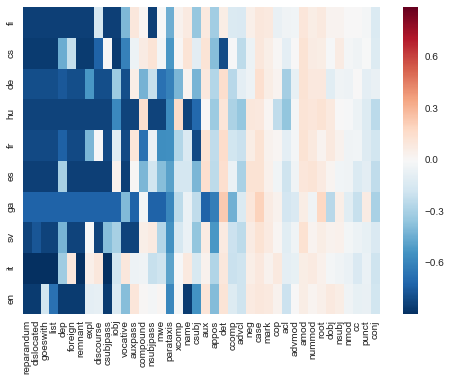

In [180]:
dep_entropy = pd.Series.from_csv('../data/crosslingual_dependency_entropy.csv').index
sttr = ["fi", "cs", "de", "hu", "fr", "es", "ga", "sv", "it", "en"]
labels_precision = pd.DataFrame({y:x['precision'] for y,x in label_result.items()}).fillna(0)
sns.heatmap(labels_precision.subtract(all_labels_results['precision'], axis=0).ix[sttr][dep_entropy]);

It's hard to read any general trends into it. That we have negative results to the left should just mean that rarely used relations are harder to predict. Not too surprising. The more evenly spread out a dependency is between the languages, the more does its result reflect the overall result of the model for that language. punct, cc, nmod are examples of relations that have similar scores as its model (a lot of white).

Irish has several classes that strongly bump up the performance more than other classes: det, case, root. 

## Parsing results difference using manual split

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content relations

In [111]:
content_results = precision_recall_filter_labels(content_relations)
content_results.sort_values("precision")

,precision,recall
ga,0.634270,0.639276
de,0.744235,0.755051
fr,0.781991,0.772156
es,0.787835,0.786304
sv,0.809207,0.803792
hu,0.825070,0.824610
en,0.832778,0.833458
fi,0.840810,0.838720
it,0.854021,0.854021
cs,0.874407,0.846257


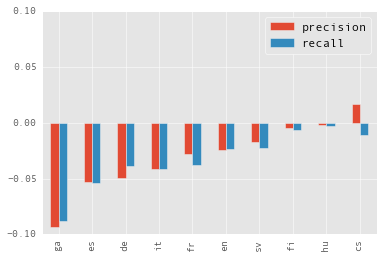

In [106]:
content_results.subtract(all_labels_results, axis=0).sort_values("precision").plot(kind='bar').set_ylim(-0.1, 0.1);

### Function relations

In [112]:
function_results = precision_recall_filter_labels(function_relations)
function_results.sort_values("precision")

,precision,recall
cs,0.833230,0.922424
ga,0.866348,0.857480
sv,0.880820,0.892445
fi,0.882876,0.893473
fr,0.883630,0.893808
hu,0.890435,0.893543
de,0.910889,0.890418
es,0.929606,0.932036
en,0.937604,0.932539
it,0.966487,0.967197


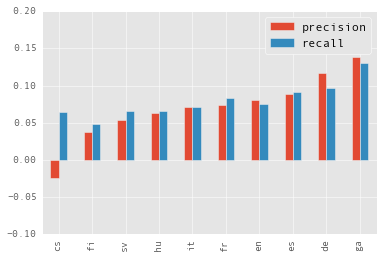

In [114]:
function_results.subtract(all_labels_results, axis=0).sort_values("precision").plot(kind='bar').set_ylim(-0.1, 0.2);

## Conclusion

It is easier for all languages to parse function dependencies than it is to parse content dependencies, with the exception of Czech. For Irish and German, the results are noticably higher. English is not as far to the right as we would have liked.

## Other classes

In [120]:
core_dependents = ("nsubj", "csubj", "nsubjpass", "csubjpass", "dobj", "ccomp", "xcomp", "iobj")
core_dependent_result = precision_recall_filter_labels(core_dependents)
core_dependent_result

,precision,recall
ga,0.605740,0.657377
de,0.686353,0.728741
es,0.820513,0.829511
hu,0.825959,0.828402
fr,0.833713,0.834664
sv,0.834365,0.822487
it,0.840956,0.828045
fi,0.864776,0.845806
cs,0.883905,0.889394
en,0.901451,0.893263


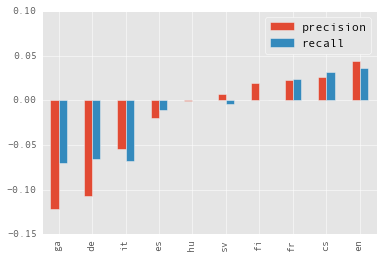

In [119]:
core_dependent_result.subtract(all_labels_results, axis=0).sort_values("precision").plot(kind='bar').set_ylim(-0.15, 0.1);

In [128]:
noun_dependents = ("nummod", "appos", "nmod", "acl", "amod", "neg")  # "det" removed
noun_dependents_result = precision_recall_filter_labels(noun_dependents)
noun_dependents_result

,precision,recall
ga,0.641582,0.618696
de,0.775851,0.767228
fr,0.805469,0.768228
es,0.821925,0.805934
sv,0.827488,0.818565
en,0.828516,0.812738
hu,0.851270,0.823392
fi,0.858288,0.850849
it,0.865707,0.869429
cs,0.886940,0.828754


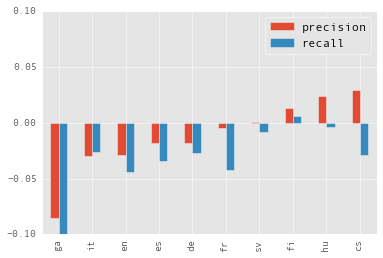

In [129]:
noun_dependents_result.subtract(all_labels_results, axis=0).sort_values("precision").plot(kind='bar').set_ylim(-0.1, 0.1);